In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.io import loadmat
import tensorflow as tf
import random
import progressbar
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, MaxPool2D, LeakyReLU

In [3]:
joint_name = ['HeadF', 'HeadB', 'HeadL', 'SpineF', 'SpineM', 'SpineL', 
            'Offset1', 'Offset2', 'HipL', 'HipR', 'ElbowL', 'ArmL', 
            'ShoulderL', 'ShoulderR', 'ElbowR', 'ArmR', 'KneeR', 
            'KneeL', 'ShinL', 'ShinR']

joints_idx = [[1, 2], [2, 3], [1, 3], [2, 4], [1, 4], [3, 4], [4, 5], 
            [5, 6], [4, 7], [7, 8], [5, 8], [5, 7], [6, 8], [6, 9], 
            [6, 10], [11, 12], [4, 13], [4, 14], [11, 13], [12, 13], 
            [14, 15], [14, 16], [15, 16], [9, 18], [10, 17], [18, 19], 
            [17, 20]]

In [4]:
# Loading mat file and returning file
def loadMatFile(fileName, key):
    mat = loadmat(fileName)[key]
    print("Loaded:",fileName, key)
    return mat

In [5]:
# Plot 3D points given file and frame number
def plotKnownOrder(matFile, numb):
    mat = matFile[numb]
    x = mat[0]
    y = mat[1]
    z = mat[2]

    # loading plot
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')

    # adding points, labels and lines
    try:
        ax.scatter(x,y,z, color='#ff5e5e', s =10, marker='x')
    except:
        pass
    # addLabels(ax, x, y, z)
    drawLines(ax, x, y, z)
    drawAllLines(ax, x, y, z)

    # Labeling plot
    ax.set_title("Rat positioning")
    ax.set_xlabel("X axis")
    ax.set_ylabel("Y axis")
    ax.set_zlabel("Z axis")
    plt.show()

# Draw major lines in the rat model
def drawLines(ax,x, y, z):
    # run through all the connections to draw the points
    for i in range(len(joints_idx)):
        try: 
            # Getting both points to draw line
            idx = joints_idx[i]
            x_line = [x[idx[0]-1], x[idx[1]-1]]
            y_line = [y[idx[0]-1], y[idx[1]-1]]
            z_line = [z[idx[0]-1], z[idx[1]-1]]
            z_coord_1 = x[idx[0]-1], y[idx[0]-1], z[idx[0]-1]
            z_coord_2 = x[idx[1]-1], y[idx[1]-1], z[idx[1]-1]

            # Draw lines
            if i < 3: 
                ax.plot(x_line, y_line, z_line, c="#064ea1", linewidth=4)
            elif i < 6:
                ax.plot(x_line, y_line, z_line, c="#64ccd1", linewidth=4)
            else:
                ax.plot(x_line, y_line, z_line, c="#46b8a7", linewidth=4)
        except:
            pass

# Draw all line from every point 
def drawAllLines(ax,x, y, z):
    joint_len = len(joint_name)
    all_lines = []
    for i in range(joint_len):
        for j in range(joint_len):
            if (not([i,j] in all_lines)):
                x_line = [x[i], x[j]]
                y_line = [y[i], y[j]]
                z_line = [z[i], z[j]]
                ax.plot(x_line, y_line, z_line, color='#b1d8fc', linewidth=0.5)
                all_lines.append([i,j])
                all_lines.append([j,i])

In [6]:
# normalizes a matrix
def normalize(matrix):
    max_numb = max(matrix[~np.isnan(matrix)])
    norm = matrix/max_numb
    return np.array(norm)
    # return matrix

In [7]:
from scipy.spatial.distance import cdist
# Get the distance to every single point 
def getAllDistances(matFile, numb):
    mat = matFile[numb]
    mat = mat.T
    dist = cdist(mat, mat, 'euclidean')
    return normalize(dist)

In [8]:
# Get the absolute height difference to every single point 
def getAllHeights(matFile, numb):
    mat = matFile[numb]
    z = mat[2]
    reshaped = int(matFile.shape[2])
    height = []

    for i in range(reshaped):
        for j in range(reshaped):
            if np.nan in [z[i], z[j]]:
                height.append(np.nan)
            else:
                height.append(np.abs(z[i]-z[j]))

    # normalizes height data
    height = normalize(np.array(height).reshape(reshaped, reshaped))
    return height


In [9]:
# Get the angle to every single point 
def getAllAngles(matFile, numb):
    mat = matFile[numb]
    mat = mat.T
    angle = cdist(mat, mat, 'cosine')
    return normalize(angle)

In [10]:
def addNans(raw):
    raw_copy = np.array(raw.copy())

    for i in range(raw_copy.shape[0]):
        rand_numb = np.random.randint(0, 4)
        rand_index = random.sample(range(3, 20), rand_numb)
        for j in range(rand_numb):
            raw_copy[i][:,rand_index[j]] = np.nan
    return raw_copy


In [11]:
def getData(data, numb): 
    cnn_inputs = []
    bar = progressbar.ProgressBar()

    for i in bar(range(numb)):
        dist = getAllDistances(data, i) 
        height = getAllHeights(data, i)
        angle = getAllAngles(data, i)
        for j in range(0, data.shape[2]):
            temp = np.array([dist[j], height[j], angle[j]])
            first = temp[:,0:3]
            second = temp[:,3:20]
            first = first [ :, first[0].argsort()]
            second = second [ :, second[0].argsort()]
            output = np.concatenate((first, second), axis =1)
            cnn_inputs.append(output)

    # DIMENTION CHANGE
    cnn_inputs = np.array(cnn_inputs)[:,:,:13]
    # cnn_inputs = np.array(cnn_inputs)[:,:,:20]
    cnn_inputs = np.array(cnn_inputs).reshape((cnn_inputs.shape[0], 39))
    # cnn_inputs = np.array(cnn_inputs).reshape((numb*data.shape[2], 60))
    where_are_NaNs = np.isnan(cnn_inputs)
    cnn_inputs[where_are_NaNs] = 0
    return cnn_inputs


In [12]:
def oneFileTestTrain():
    mat_file = loadmat('mat_files/markerSplit_1_shuffled.mat')
    data = mat_file['alteredM']
    labels = mat_file['labelsM']

    # set numb of data used
    numb_train = 2000
    numb_test = 2000

    # find length of data
    mat_len = int(len(labels))
    mat_half = int(mat_len/2)

    # Take some frames from the list to use as trian and test data
    index_train = np.linspace(0, mat_half, num = numb_train, endpoint=False).astype(int)
    index_test = np.linspace(mat_half, mat_len, num = numb_test, endpoint=False).astype(int)
    pre_train_data = data[index_train]
    pre_train_labels = labels[index_train]
    pre_test_data = data[index_test]
    pre_test_labels = labels[index_test]

    print("Shape of pre_train_data:", pre_train_data.shape)
    print("Shape of pre_test_data:", pre_test_data.shape)
    print("Shape of pre_train_labels:", pre_train_labels.shape)
    print("Shape of pre_test_labels:", pre_test_labels.shape)
    return pre_train_data, pre_test_data, pre_train_labels, pre_test_labels

In [13]:
train_file = loadmat('mat_files/bigSet1.mat')
test_file = loadmat('mat_files/bigSet2.mat')

In [14]:
train_data = train_file['bigSet1']
test_data = test_file['bigSet2']
train_labels = train_file['labels1']
test_labels = test_file['labels2']
# set numb of data used
numb_train = len(train_data)
numb_test = 1000

# Take some frames from the list to use as trian and test data
index_train = np.linspace(0, len(train_labels), num = numb_train, endpoint=False).astype(int)
index_test = np.linspace(0, len(test_labels), num = numb_test, endpoint=False).astype(int)
# pre_train_data = train_data[index_train]
# pre_train_labels = train_labels[index_train]
pre_train_data = train_data
pre_train_labels = train_labels
pre_test_data = test_data[index_test]
pre_test_labels = test_labels[index_test]

print("Shape of pre_train_data:", pre_train_data.shape)
print("Shape of pre_test_data:", pre_test_data.shape)
print("Shape of pre_train_labels:", pre_train_labels.shape)
print("Shape of pre_test_labels:", pre_test_labels.shape)


Shape of pre_train_data: (221147, 3, 20)
Shape of pre_test_data: (1000, 3, 20)
Shape of pre_train_labels: (221147, 20)
Shape of pre_test_labels: (1000, 20)


In [15]:
# Get measurement data for every 3D point
train_data = getData(pre_train_data, numb_train)
test_data = getData(pre_test_data, numb_test)

# Flatten the trian labels to fit dimentions of data
train_labels = pre_train_labels.flatten()[0:(numb_train*20)]-1
test_labels = pre_test_labels.flatten()[0:(numb_test*20)]-1

print("Shape of train_data:", train_data.shape)
print("Shape of test_data:", test_data.shape)
print("Shape of train_labels:", train_labels.shape)
print("Shape of test_labels:", test_labels.shape)

100% (221147 of 221147) |################| Elapsed Time: 0:07:22 Time:  0:07:22
100% (1000 of 1000) |####################| Elapsed Time: 0:00:01 Time:  0:00:01


Shape of train_data: (4422940, 39)
Shape of test_data: (20000, 39)
Shape of train_labels: (4422940,)
Shape of test_labels: (20000,)


In [17]:
# Get index where the data is all 0
nans_train = np.sort(np.where(~train_data.any(axis=1))[0])[::-1]
nans_test = np.sort(np.where(~test_data.any(axis=1))[0])[::-1]

# Turn data into lists
train_data_new = list(train_data)
test_data_new = list(test_data)
train_labels_new = list(train_labels)
test_labels_new = list(test_labels)

bar = progressbar.ProgressBar()
# Remove the nan values 
for i in bar(nans_train):
    train_data_new.pop(i)
    train_labels_new.pop(i)
bar = progressbar.ProgressBar()
for i in bar(nans_test):
    test_data_new.pop(i)
    test_labels_new.pop(i)

# Turn data back into array
train_data_new = np.array(train_data_new)
train_labels_new = np.array(train_labels_new)
test_data_new = np.array(test_data_new)
test_labels_new = np.array(test_labels_new)

print("Shape of train_data_new:", train_data_new.shape)
print("Shape of test_data_new:", test_data_new.shape)
print("Shape of train_labels_new:", train_labels_new.shape)
print("Shape of test_labels_new:", test_labels_new.shape)

100% (397563 of 397563) |################| Elapsed Time: 0:39:58 Time:  0:39:58
100% (1741 of 1741) |####################| Elapsed Time: 0:00:00 Time:  0:00:00


Shape of train_data_new: (4025377, 39)
Shape of test_data_new: (18259, 39)
Shape of train_labels_new: (4025377,)
Shape of test_labels_new: (18259,)


In [18]:
# Creates the ML training platform to predict rat joints
def ml_traning(train_data, train_labels, test_data, test_labels):
    # DIMENTION CHANGE
    train_data = train_data.reshape(train_data.shape[0], 39)
    test_data = test_data.reshape(test_data.shape[0], 39)
    # train_data = train_data.reshape(train_data.shape[0], 60)
    # test_data = test_data.reshape(test_data.shape[0], 60)
    train_data = train_data.astype('float32')
    test_data = test_data.astype('float32')

    model = createModel()
    model.compile(optimizer='adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(x=train_data,y=train_labels, verbose='auto', batch_size=20, epochs=2)
    
    output = model.evaluate(test_data, test_labels)
    print("Loss:", output[0])
    print("Accuracy:", output[1]*100)
    return model

# Creates the model for the CNN
def createModel():
    model = Sequential()
    model.add(Dense(120, activation= LeakyReLU()))
    model.add(Dense(320, activation= LeakyReLU()))
    # model.add(Dropout(rate=0.25))
    model.add(Dense(80, activation= LeakyReLU()))
    # model.add(Dense(13, activation = "softmax"))
    model.add(Dense(len(joint_name), activation = "softmax"))
    return model

In [19]:
skeleton_model = ml_traning(train_data_new, train_labels_new, test_data_new, test_labels_new)

Epoch 1/2
201269/201269 [==============================] - 400s 2ms/step - loss: 0.5561 - accuracy: 0.8178
Epoch 2/2
571/571 [==============================] - 1s 2ms/step - loss: 0.6724 - accuracy: 0.8200
Loss: 0.672447144985199
Accuracy: 82.00339674949646


In [20]:
# Tests individual points and tells you if the CNN worked
def handTest(image_index, test_data, label, model, maxNumb):
    max_index = len(joint_name)*maxNumb-1
    if image_index <= max_index:
        predict(test_data, image_index, label, model)
    else:
        print("ERROR: Your predict_index must be below", max_index)

# Showing individual predictions
def predict(data, image_index, label, model):
    img = [data[image_index]]
    # DIMENTION CHANGE
    img = np.array(img).reshape(3,13)
    # img = np.array(img).reshape(3,20)
    plt.imshow(img)
    plt.show()

    pred = model.predict(img.reshape(1, 39))
    # pred = model.predict(img.reshape(1, 60))
    predict = pred.argmax()
    actual = label[image_index]

    print("Actual:", actual)
    print("Predicted:", predict)
    
    if predict == actual:
        print("YAY ✿(ᵔ‿ᵔ)")
    else:
        print("Wrong (◕︵◕)")

    

In [21]:
# temp = test_data[0].reshape(3,13)
# print(temp)
# plt.imshow(temp)

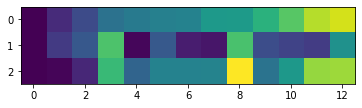

Actual: 0
Predicted: 0
YAY ✿(ᵔ‿ᵔ)


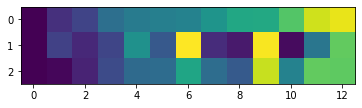

Actual: 1
Predicted: 1
YAY ✿(ᵔ‿ᵔ)


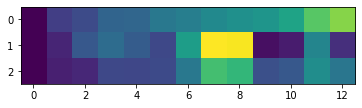

Actual: 2
Predicted: 2
YAY ✿(ᵔ‿ᵔ)


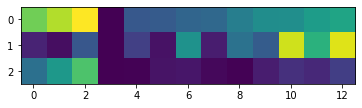

Actual: 7
Predicted: 7
YAY ✿(ᵔ‿ᵔ)


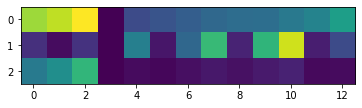

Actual: 5
Predicted: 5
YAY ✿(ᵔ‿ᵔ)


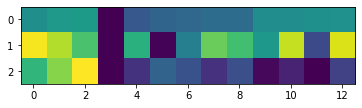

Actual: 10
Predicted: 10
YAY ✿(ᵔ‿ᵔ)


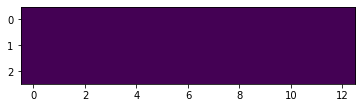

Actual: 11
Predicted: 10
Wrong (◕︵◕)


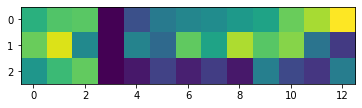

Actual: 13
Predicted: 13
YAY ✿(ᵔ‿ᵔ)


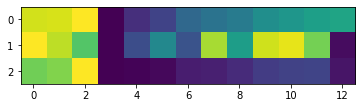

Actual: 19
Predicted: 18
Wrong (◕︵◕)


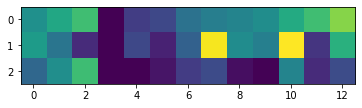

Actual: 12
Predicted: 12
YAY ✿(ᵔ‿ᵔ)


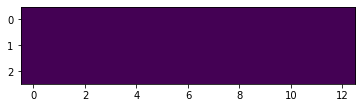

Actual: 14
Predicted: 10
Wrong (◕︵◕)


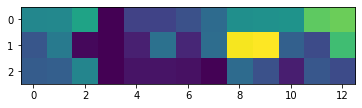

Actual: 3
Predicted: 3
YAY ✿(ᵔ‿ᵔ)


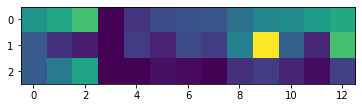

Actual: 6
Predicted: 6
YAY ✿(ᵔ‿ᵔ)


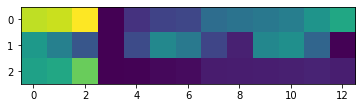

Actual: 9
Predicted: 9
YAY ✿(ᵔ‿ᵔ)


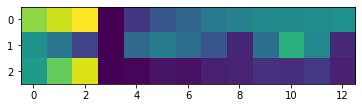

Actual: 17
Predicted: 17
YAY ✿(ᵔ‿ᵔ)


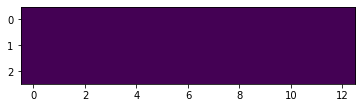

Actual: 8
Predicted: 10
Wrong (◕︵◕)


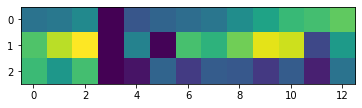

Actual: 15
Predicted: 15
YAY ✿(ᵔ‿ᵔ)


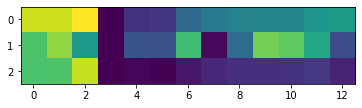

Actual: 16
Predicted: 16
YAY ✿(ᵔ‿ᵔ)


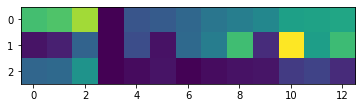

Actual: 4
Predicted: 4
YAY ✿(ᵔ‿ᵔ)


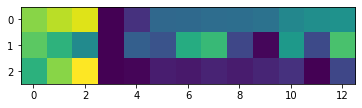

Actual: 18
Predicted: 18
YAY ✿(ᵔ‿ᵔ)


In [22]:
for i in range(420,440):
    handTest(i, test_data, test_labels, skeleton_model, numb_test)

Train input


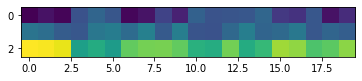

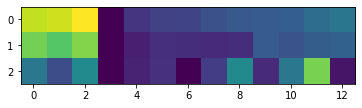

Test input


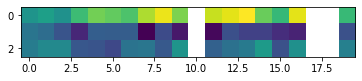

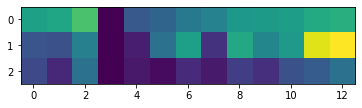

In [23]:
index = 1234
frame = int(index/20)

print("Train input")
plt.imshow(pre_train_data[frame].reshape(3,20))
plt.show()
# DIMENTION CHANGE
plt.imshow(train_data[index].reshape(3,13))
# plt.imshow(train_data[index].reshape(3,20))
plt.show()

print("Test input")
plt.imshow(pre_test_data[frame].reshape(3,20))
plt.show()
plt.imshow(test_data[index].reshape(3,13))
# plt.imshow(test_data[index].reshape(3,20))
plt.show()

In [24]:
temporal = loadmat('mat_files/newcombed.mat')

In [64]:
file_times = temporal['Newcombed']
transpose_time = file_times.reshape((len(file_times), 3*file_times.shape[2])).T
print(transpose_time.shape)
numb_times = 3000
test_time = transpose_time[:,:numb_times]

(66, 540000)


In [237]:
chunks = []
bar = progressbar.ProgressBar()
for i in bar(range(int(test_time.shape[0]/3))):
    row = i*3
    row_list = []
    temp_list = []
    for j in range(test_time.shape[1]):
        if ~np.isnan(test_time[i][j]):
            temp_list.append(j)
        else:
            if len(temp_list) > 0:
                row_list.append(temp_list)
                temp_list = []
    if len(temp_list) > 0:
        row_list.append(temp_list)
    chunks.append([i, row_list])

100% (22 of 22) |########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [203]:
time_data = file_times.reshape((len(file_times), 3*file_times.shape[2]))
select_time = time_data[:numb_times]
input_time = select_time.reshape(select_time.shape[0], 3, int(select_time.shape[1]/3)).astype(float)
processed_time = getData(input_time, numb_times)
print(processed_time.shape)

100% (3000 of 3000) |####################| Elapsed Time: 0:00:08 Time:  0:00:08


(66000, 39)


In [196]:
presplit_process = np.transpose(processed_time.reshape(numb_times, int(test_time.shape[0]/3), processed_time.shape[1]),(1, 0, 2))
# zeros = np.zeros(39)
# print(presplit_process.shape)
# cur = []
# i = 7
# for j in range(numb_times):
#     if np.array_equal(zeros, np.array(presplit_process[i][j])):
#         cur.append(i)
# print(len(cur))


(22, 3000, 39)
1502


In [291]:
chunks = np.array(chunks, dtype=object)
print(chunks.shape)
# for i in range(22):
#     print(np.array(chunks[i][0]), np.array(chunks[i][1], dtype=object).shape, np.array(chunks[i][1][0], dtype=object).shape)
for i in range(len(chunks[1][1])):
    print(len(chunks[1][1][i]))

(22, 2)
3000


In [442]:
print("hi"+str(1))

hi1


In [502]:
from scipy import stats
temporal_data = []
for i in range(len(chunks)):
# for i in range(1):
    chunck_range = []
    predict = []
    certianty = []

    point = chunks[i][0]
    chuck_data = chunks[i][1]
    print("\nPoint: ("+ str(point) + ", " + str(len(chuck_data))+")")

    for j in range(len(chuck_data)):
        first = chunks[i][1][j][0]
        last = chunks[i][1][j][-1]
        range_output = []

        if first is not last:
            range_output = [point, first, last]
        else:
            range_output = [point, first, first]
        chunck_range.append(range_output)
        chunk_length = last-first+1

        temp_pred = []
        temp_certianty = []
        for k in (range(first, (last+1))): 
            processed_data = presplit_process[i][k]
            model_pred = skeleton_model.predict(processed_data.reshape(1, 39))
            if len(temp_pred) == 0: 
                temp_pred = model_pred[0]
            else:
                temp_pred += model_pred[0]
            temp_certianty.append(model_pred.argmax())
        
        temp_pred = np.array(temp_pred)
        temp_certianty = np.array(temp_certianty)
        
        mode = stats.mode(temp_certianty, axis = 0)
        mode_pred = mode[0].flatten()[0]
        mode_count = mode[1].flatten()[0]
        mode_conf = mode_count/chunk_length

        certianty_pred = temp_pred.argmax()
        certianty_conf = temp_pred.max()/chunk_length
        certianty_count = (temp_certianty == certianty_pred).sum()

        predict.append([mode_pred, mode_conf, mode_count, chunk_length])
        certianty.append([certianty_pred, certianty_conf, certianty_count, chunk_length])

        print(str(j) + ") (" + str(mode_pred) + ", " + str(certianty_pred) + ") ( [" + str(mode_count) + ", " + str(certianty_count) + "] /", chunk_length, ")", end = " ")
        if (mode_pred == certianty_pred):
            print("Yay")
        else:
            print("Conflict")

    temporal_data.append([point, chunck_range, predict, certianty])


Point: (0, 1)
0) (2, 2) ( [2517, 2517] / 3000 ) Yay

Point: (1, 1)
0) (1, 1) ( [3000, 3000] / 3000 ) Yay

Point: (2, 1)
0) (0, 0) ( [2019, 2019] / 3000 ) Yay

Point: (3, 1)
0) (4, 4) ( [2908, 2908] / 3000 ) Yay

Point: (4, 1)
0) (5, 5) ( [2877, 2877] / 3000 ) Yay

Point: (5, 1)
0) (7, 5) ( [1535, 1390] / 3000 ) Conflict

Point: (6, 1)
0) (5, 5) ( [2890, 2890] / 3000 ) Yay

Point: (7, 11)
0) (15, 15) ( [188, 188] / 191 ) Yay
1) (15, 15) ( [23, 23] / 23 ) Yay
2) (15, 15) ( [115, 115] / 129 ) Yay
3) (15, 15) ( [569, 569] / 1087 ) Yay
4) (11, 11) ( [12, 12] / 12 ) Yay
5) (11, 11) ( [15, 15] / 15 ) Yay
6) (14, 14) ( [1, 1] / 1 ) Yay
7) (15, 15) ( [4, 4] / 4 ) Yay
8) (15, 15) ( [2, 2] / 2 ) Yay
9) (15, 15) ( [28, 28] / 28 ) Yay
10) (10, 11) ( [3, 2] / 6 ) Conflict

Point: (8, 1)
0) (17, 17) ( [2265, 2265] / 3000 ) Yay

Point: (9, 1)
0) (16, 16) ( [2729, 2729] / 3000 ) Yay

Point: (10, 1)
0) (7, 7) ( [1986, 1986] / 3000 ) Yay

Point: (11, 12)
0) (15, 15) ( [45, 45] / 45 ) Yay
1) (15, 15) ( [

In [448]:
for i in range(4): 
    print(temporal_data[7][i], "\n")

7 

[[7, 0, 190], [7, 192, 214], [7, 216, 344], [7, 346, 1432], [7, 2231, 2242], [7, 2247, 2261], [7, 2282], [7, 2392, 2395], [7, 2397, 2398], [7, 2450, 2477], [7, 2859, 2864]] 

[[15, 0.9842931937172775, 188, 191], [15, 1.0, 23, 23], [15, 0.8914728682170543, 115, 129], [15, 0.5234590616375345, 569, 1087], [11, 1.0, 12, 12], [11, 1.0, 15, 15], [14, 1.0, 1, 1], [15, 1.0, 4, 4], [15, 1.0, 2, 2], [15, 1.0, 28, 28], [10, 0.5, 3, 6]] 

[[15, 0.8245362286792376, 188, 191], [15, 0.8126996081808339, 23, 23], [15, 0.772588567216267, 115, 129], [15, 0.5513905347106428, 569, 1087], [11, 0.7387017409006754, 12, 12], [11, 0.7627864837646484, 15, 15], [14, 0.7719788551330566, 1, 1], [15, 0.8472898006439209, 4, 4], [15, 0.9344401955604553, 2, 2], [15, 0.7398898260934013, 28, 28], [11, 0.34896183013916016, 2, 6]] 



In [513]:
temp_copy = temporal_data.copy()
pred_data = np.array(temp_copy, dtype=object)
chunk_data = []

# print(pred_data[:,1][21])
# print(pred_data[:,2][21])
# print(pred_data[:,3][21])

for i in range(20):
    chunk_data.append([])

for i in range(22):
    index = pred_data[:,1][i]
    # pred = pred_data[:,2][i] # mode
    pred = pred_data[:,3][i] # certainty 
    for j in range(len(index)):
        if len(index[j]) == 3:
            length = index[j][2]-index[j][1] + 1
        else:
            length = 1
        add_data = pred[j] + [length] + index[j]
        chunk_data[add_data[0]].append(add_data)

for i in range(len(chunk_data)):
    print(i, len(chunk_data[i]))

0 13
1 21
2 3
3 16
4 1
5 33
6 0
7 1
8 2
9 0
10 8
11 37
12 1
13 15
14 1
15 35
16 2
17 1
18 1
19 1


In [504]:
print(chunk_data[3])

[[3, 0.5306800944010417, 1940, 3000, 3000, 12, 0, 2999], [3, 0.660064697265625, 2, 2, 2, 17, 102, 103], [3, 0.8709016442298889, 1, 1, 1, 17, 1136, 1136], [3, 0.8354716897010803, 2, 2, 2, 17, 1148, 1149], [3, 0.44531741738319397, 4, 4, 4, 17, 2359, 2362], [3, 0.4699004491170247, 3, 3, 3, 17, 2365, 2367], [3, 0.48637187480926514, 4, 4, 4, 17, 2377, 2380], [3, 0.46294326782226564, 5, 5, 5, 17, 2393, 2397], [3, 0.5199193954467773, 2, 2, 2, 17, 2399, 2400], [3, 0.5233662605285645, 15, 15, 15, 17, 2406, 2420], [3, 0.5213212370872498, 8, 8, 8, 17, 2422, 2429], [3, 0.5221855640411377, 1, 1, 1, 17, 2438, 2438], [3, 0.524651050567627, 1, 1, 1, 17, 2440, 2440], [3, 0.5175662040710449, 2, 2, 2, 17, 2446, 2447], [3, 0.9995989004770914, 3, 3, 3, 19, 1236, 1238], [3, 0.9999302311947471, 19, 19, 19, 19, 1335, 1353]]


In [615]:
prepross = []
# for i in range(len(chunk_data)): 
for i in range(20): 
    current = chunk_data[i]
    sorted_current = sorted(current,key=lambda x: x[4])
    numb_index = []
    bounds = None
    for j in reversed(range(len(sorted_current))):
        input_index = sorted_current[j][5:8]
        current_bounds = np.arange(input_index[1], input_index[2]+1)
        if len(numb_index) == 0:
            numb_index.append(input_index)
            bounds = current_bounds.tolist()
        else:
            temp_curent = current_bounds.tolist()
            # gets overlapping elements 
            same = list(set(temp_curent) & set(bounds))

            # no overlapp between the two lists
            if len(same) == 0:
                numb_index.append(input_index)
                bounds += temp_curent
            else:
                if temp_curent[0] in bounds and temp_curent[-1] in bounds:
                    # print("Can't add index in range [" + str(temp_curent[0]) + ", " + str(temp_curent[-1]) + "] to [" + str(bounds[0])+ ", " + str(bounds[-1]) + "]")
                    break
                
                # just in case
                
                # lower bound is inside current bound
                if temp_curent[0] in bounds:
                    print("lower", temp_curent[0], bounds[-1], temp_curent[0], temp_curent[-1])
                    lower = bounds[-1]
                    higher = temp_curent[-1]
                    new_index = [input_index[0],lower, higher]
                    new_bounds = np.arange(lower, higher+1).tolist()

                    numb_index.append(new_index)
                    bounds += new_bounds
                # higher bound is inside current bound
                elif temp_curent[-1] in bounds:
                    print("upper")
                    lower = temp_curent[0]
                    higher = bounds[0]
                    new_index = [input_index[0],lower, higher]
                    new_bounds = np.arange(lower, higher+1).tolist()

                    numb_index.append(new_index)
                    bounds += new_bounds
        bounds = sorted(bounds)
    prepross.append([i, numb_index, bounds])        

    # print(i, numb_index)
    # pic = np.zeros(3001)
    # for j in range(len(numb_index)):
    #     temp_range = np.arange(numb_index[j][1], numb_index[j][2]+1)
    #     for k in temp_range:
    #         pic[k] += 1
    # plt.imshow([pic], interpolation='nearest', aspect=300)
    # plt.show()
    
 